### Exploration of digikam4.db
sqliteviewer.app used to explore table structure beforehand.


In [2]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

conn = sqlite3.connect('digikam4.db')  # Creates a new database file if it doesn’t exist
cursor = conn.cursor()

query = "SELECT name FROM sqlite_master WHERE type='table'"
cursor.execute(query)
result = cursor.fetchall()

print(result)

[('AlbumRoots',), ('Albums',), ('Images',), ('ImageInformation',), ('ImageMetadata',), ('VideoMetadata',), ('ImagePositions',), ('ImageComments',), ('ImageCopyright',), ('Tags',), ('TagsTree',), ('ImageTags',), ('ImageProperties',), ('Searches',), ('DownloadHistory',), ('Settings',), ('ImageHistory',), ('ImageRelations',), ('TagProperties',), ('ImageTagProperties',)]


Important tables:
- Images: contains image name and ID for images. 389933 rows. Issue: does not have values for album (origin folder of image)
- ImageInformation: contains creation date for image IDs
- Tags: contains the ID and names for 53 different tags
- ImageTags: maps image ids to tags (many to many)
- Albums: Ids and names of paths to folders where images are located (correspond to trail cameras)

## What is the distribution of the tags?
Ignoring tags that do nor reffer a specific species (eg: tags called species, Unconfirmed, etc)

In [14]:
# Print tags and tag IDs 
query = """
SELECT id, name from Tags
"""

cursor.execute(query)
results = cursor.fetchall()

print(f"Tag ID   |    Tag Name")
print("---------------------------")
for entry in results:
    print(f"{entry[0]}   |    {entry[1]}")

Tag ID   |    Tag Name
---------------------------
20   |    Asian palm civet
24   |    Barking deer
26   |    Birds
25   |    Blue sheep
41   |    Color Label Black
38   |    Color Label Blue
40   |    Color Label Gray
37   |    Color Label Green
39   |    Color Label Magenta
33   |    Color Label None
35   |    Color Label Orange
34   |    Color Label Red
42   |    Color Label White
36   |    Color Label Yellow
11   |    Common leopard
2   |    Current Version
48   |    Dogs
12   |    Himalayan black bear
13   |    Himalayan brown bear
23   |    Himalayan goral
31   |    Himalayan gray langur
53   |    Himalayan serrow
22   |    Himalayan tahr
51   |    Hunter
6   |    Ignored
17   |    Leopard cat
30   |    Livestocks
47   |    Locals
19   |    Mountain weasel
8   |    Need Resolving History
9   |    Need Tagging History Graph
4   |    People
46   |    Pick Label Accepted
43   |    Pick Label None
45   |    Pick Label Pending
44   |    Pick Label Rejected
50   |    Porcupine
16   | 

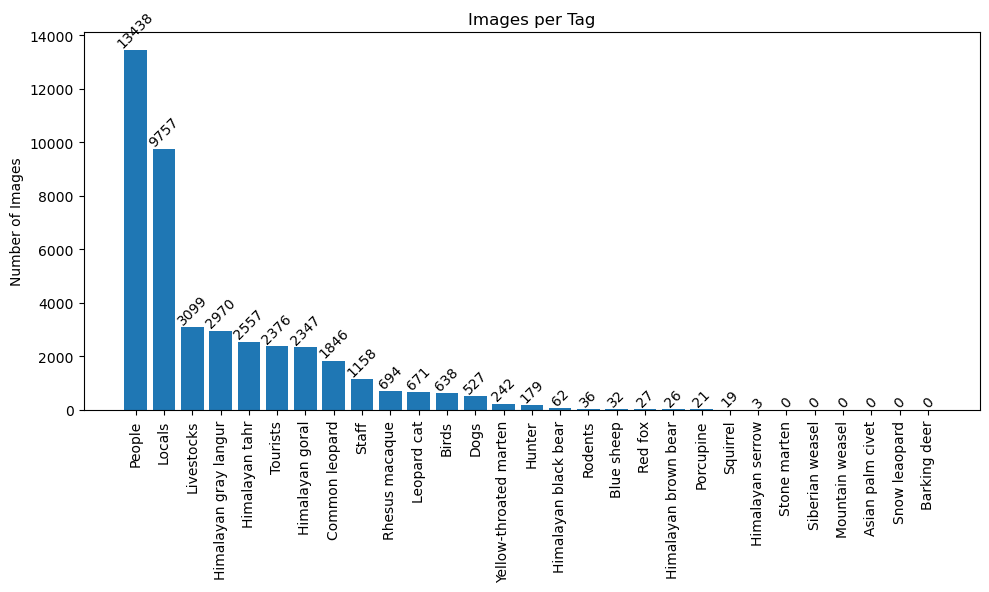

In [3]:
# Get number of images per tag and display in a bar chart

Ignored_tag_Ids = [1,2,3,5,6,7,8,9,10,33,34,35,36,37,38,39,40,41,42,43,44,45,46,49,]

ignored_str = ",".join(map(str, Ignored_tag_Ids))


query = f"""
SELECT
    tg.id,
    tg.name,
    COUNT(it.imageid) AS image_count
FROM Tags tg
LEFT JOIN ImageTags it
    ON tg.id = it.tagid
WHERE tg.id NOT IN ({ignored_str})
GROUP BY tg.id
ORDER BY image_count DESC """

cursor.execute(query)
results = cursor.fetchall()

tag_names = [row[1] for row in results]
counts = [row[2] for row in results]

plt.figure(figsize=(10,6))
bars = plt.bar(tag_names, counts)

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # x position (center of bar)
        height,                           # y position (top of bar)
        str(height),                      # text to display
        ha='center',
        va='bottom',
        rotation=45
    )

plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.title("Images per Tag")
plt.tight_layout()
plt.show()

Number of Images with any Tag: [(28327,)]
Number of Images without Ignored tags: [(28190,)]
Number of Images without the colour label and pick label tags: [(28216,)]


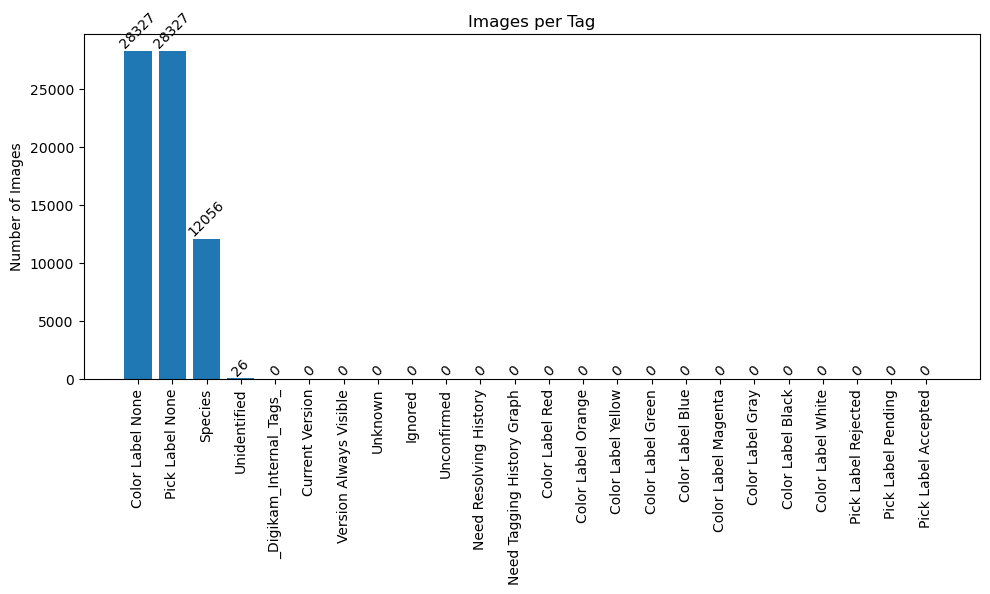

In [4]:
# Looking into the non-species labels
query = f"""
SELECT COUNT(DISTINCT imageid)
FROM ImageTags;
"""
cursor.execute(query)
results = cursor.fetchall()

print(f"Number of Images with any Tag: {results}")
query = f"""
SELECT COUNT(DISTINCT imageid)
FROM ImageTags
WHERE tagid NOT IN ({ignored_str});
"""
cursor.execute(query)
results = cursor.fetchall()

print(f"Number of Images without Ignored tags: {results}")

query = f"""
SELECT COUNT(DISTINCT imageid)
FROM ImageTags
WHERE tagid NOT BETWEEN 33 AND 46;
"""
cursor.execute(query)
results = cursor.fetchall()

print(f"Number of Images without the colour label and pick label tags: {results}")

query = f"""
SELECT
    tg.id,
    tg.name,
    COUNT(it.imageid) AS image_count
FROM Tags tg
LEFT JOIN ImageTags it
    ON tg.id = it.tagid
WHERE tg.id IN ({ignored_str})
GROUP BY tg.id
ORDER BY image_count DESC """

cursor.execute(query)
results = cursor.fetchall()

tag_names = [row[1] for row in results]
counts = [row[2] for row in results]

plt.figure(figsize=(10,6))
bars = plt.bar(tag_names, counts)

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # x position (center of bar)
        height,                           # y position (top of bar)
        str(height),                      # text to display
        ha='center',
        va='bottom',
        rotation=45
    )

plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.title("Images per Tag")
plt.tight_layout()
plt.show()

In [ ]:
# How many non human tagged images are there?

Human_tags = [4,47,51,27,28] + Ignored_tag_Ids
ignored_str = ",".join(map(str, Human_tags))

query = f"""
SELECT COUNT(DISTINCT imageid)
FROM ImageTags
WHERE tagid NOT IN ({ignored_str});
"""

cursor.execute(query)
results = cursor.fetchall()

print(f"Number of Images without Human tags: {results}")

Number of Images without Human tags: [(15678,)]


Notes:
- There are 28327 tagged images, all of which have the labels "Color Label None" and "Pick Label None", so these labels are meaningless.
- There are 12056 images with the species tag
- There are 15678 images without human or ignored tags

## Night vision Images
How many night vision images are there (between 7pm and 6am)?<br>
For each species, how many night vision images are there?

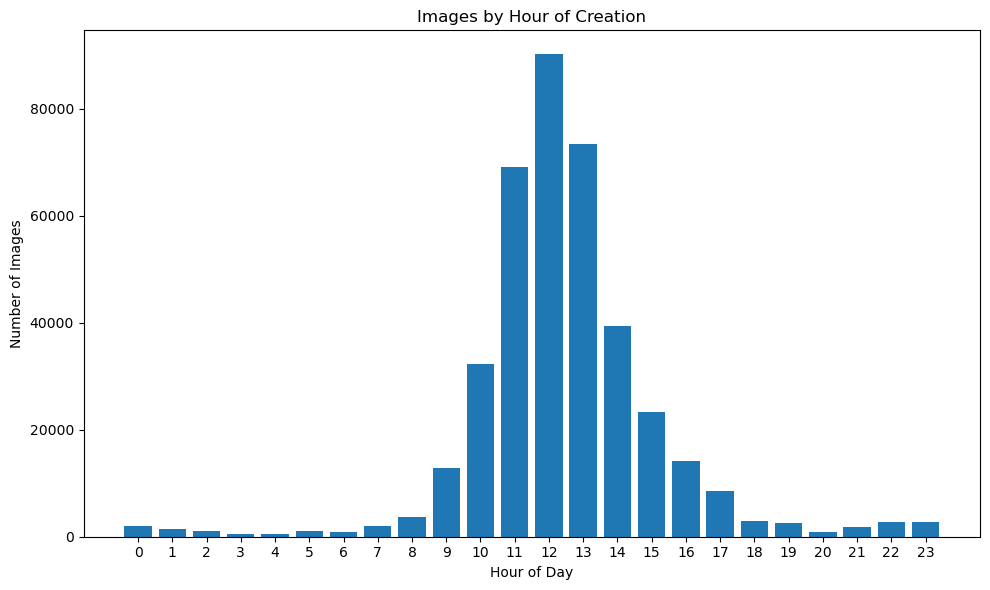

Number of images between 7pm and 6am (likely nightvision): 17337


In [ ]:
# TODO: remove untagged images!
query = """ 
SELECT 
    CAST(strftime('%H', ii.creationDate) AS INTEGER) AS hour_of_day,
    COUNT(*) AS image_count
FROM Images i
JOIN ImageInformation ii
    ON i.id = ii.imageid
GROUP BY hour_of_day
ORDER BY hour_of_day;
"""
cursor.execute(query)
results = cursor.fetchall()

hours = [row[0] for row in results]
counts = [row[1] for row in results]
plt.figure(figsize=(10,6))
plt.bar(hours, counts)

# Force x-axis to show every hour
plt.xticks(np.arange(0, 24, 1))

plt.xlabel("Hour of Day")
plt.ylabel("Number of Images")
plt.title("Images by Hour of Creation")
plt.tight_layout()
plt.show()

query = """ 
SELECT 
    COUNT(*) AS night_image_count
FROM Images i
JOIN ImageInformation ii
    ON i.id = ii.imageid
WHERE 
    CAST(strftime('%H', ii.creationDate) AS INTEGER) >= 19
    OR
    CAST(strftime('%H', ii.creationDate) AS INTEGER) < 6;
"""

cursor.execute(query)
results = cursor.fetchall()
print(f"Number of images between 7pm and 6am (likely nightvision): {results[0][0]}")
# TODO: expressa as a percent of total!

In [ ]:
SpeciesID_list = [4,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,50,51,52,53]

query = """ 
Join tables Images and ImageInformation on id = imageid,
then join with Imagetags on id (from Images) = imageid
then join with Tags table on tagid (from ImageTags) = id
Plot mini time histogram 
"""